## Import packages, including multipopulation extensions

In [1]:
#### General packages

from matplotlib import pyplot as plt
%matplotlib inline
import autograd.numpy as np
import autograd.numpy.random as npr

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")
sns.set_style('ticks',{"xtick.major.size":8,
"ytick.major.size":8})
from ssm.plots import gradient_cmap, white_to_color_cmap

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [2]:
#### SSM PACKAGES ###

import ssm
from ssm.variational import SLDSMeanFieldVariationalPosterior, SLDSTriDiagVariationalPosterior, \
	SLDSStructuredMeanFieldVariationalPosterior
from ssm.util import random_rotation, find_permutation, relu

from extensions.mp_srslds.emissions_ext import GaussianOrthogonalCompoundEmissions, PoissonOrthogonalCompoundEmissions
from extensions.mp_srslds.transitions_ext import StickyRecurrentOnlyTransitions, StickyRecurrentTransitions

## Simulate data

In [3]:
K=3 #Number of discrete states

num_gr=3 #Number of populations
num_per_gr=5 #Number of latents per population
neur_per_gr=75 #Number of neurons per population

t_end=5000 #number of time bins
num_trials=1 #number of trials

In [4]:
#Vector containing number of latents per population
D_vec=[]
for i in range(num_gr):
    D_vec.append(num_per_gr) 

#Vector containing number of neurons per population
N_vec=[]
for i in range(num_gr):
    N_vec.append(neur_per_gr)


D=np.sum(D_vec)
num_gr=len(D_vec)
D_vec_cumsum = np.concatenate(([0], np.cumsum(D_vec)))

gauss_comp_emissions=GaussianOrthogonalCompoundEmissions(N=np.sum(N_vec),K=1,D=np.sum(D_vec),D_vec=D_vec,N_vec=N_vec)
poiss_comp_emissions=PoissonOrthogonalCompoundEmissions(N=np.sum(N_vec),K=1,D=np.sum(D_vec),D_vec=D_vec,N_vec=N_vec,link='softplus')

np.random.seed(108)


In [5]:
alphas=.03+.1*np.random.rand(K) #Determines the distribution of values in the dynamics matrix, for each discrete state
print('alphas:', alphas)

sparsity=.33 #Proportion of non-diagonal blocks in the dynamics matrix that are 0

e1=.1 #Amount of noise in the dynamics

alphas: [0.05336111 0.03343876 0.08800889]


## Create (somewhat) realistic simulated data

In [6]:
np.random.seed(10)

A_masks=[]

A_all=np.zeros([K,D,D])
b_all=np.zeros([K,D])

true_sro_trans=StickyRecurrentOnlyTransitions(K=K,D=np.sum(D_vec))

true_slds = ssm.SLDS(N=np.sum(N_vec),K=K,D=int(np.sum(D_vec)),
             dynamics="gaussian",
             emissions=poiss_comp_emissions,
             transitions=true_sro_trans)

v=.2+.2*np.random.rand(1)

for k in range(K):
    inc=np.copy(k)
    true_slds.transitions.Rs[k,D_vec_cumsum[inc]:D_vec_cumsum[inc]+1]=v
    true_slds.transitions.Ss[k,D_vec_cumsum[inc]:D_vec_cumsum[inc]+1]=v-.1

true_slds.transitions.r=0*np.ones([K,1])
true_slds.transitions.s=5*np.ones([K,1])


for k in range(K):

    ##Create dynamics##
    alpha=alphas[k]


    A_mask=np.random.rand(num_gr,num_gr)>sparsity

    A_masks.append(A_mask)

    for i in range(num_gr): 
        A_mask[i,i]=1

    A0=np.zeros([D,D])
    for i in range(D-1):
        A0[i,i+1:]=alpha*np.random.randn(D-1-i)
    A0=(A0-A0.T)

    for i in range(num_gr):
        A0[D_vec_cumsum[i]:D_vec_cumsum[i+1],D_vec_cumsum[i]:D_vec_cumsum[i+1]]=2*A0[D_vec_cumsum[i]:D_vec_cumsum[i+1],D_vec_cumsum[i]:D_vec_cumsum[i+1]]


    A0=A0+np.identity(D)
    A=A0*np.kron(A_mask, np.ones((num_per_gr, num_per_gr)))

    A=A/(np.max(np.abs(np.linalg.eigvals(A)))+.01) #.97

    b=1*np.random.rand(D) #.1

    A_all[k]=A
    b_all[k]=b

true_slds.dynamics.As=A_all
true_slds.dynamics.bs=b_all

zs, xs, _ = true_slds.sample(t_end)
tmp=np.mean(relu(np.dot(true_slds.emissions.Cs[0],xs.T)+.1*true_slds.emissions.ds[0][:,None]).T)
mult=.25/tmp
lams=relu(mult*np.dot(true_slds.emissions.Cs[0],xs.T)+.1*true_slds.emissions.ds[0][:,None]).T
ys=np.random.poisson(lams)

## Plot simulated data

### Dynamics matrices

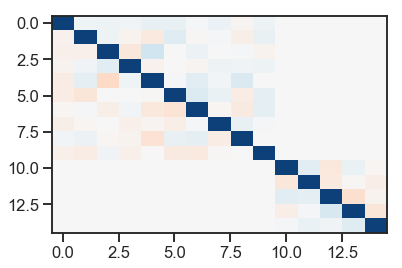

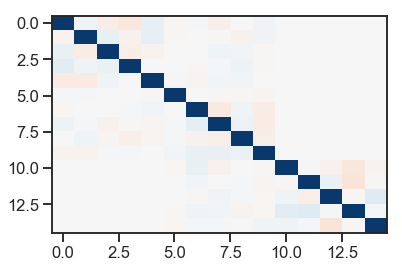

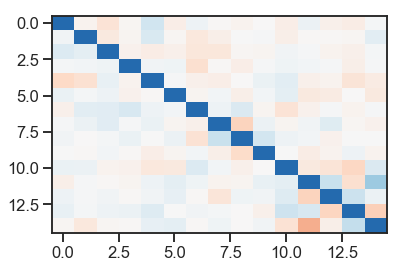

In [7]:
for k in range(K):
    plt.figure()    
    plt.imshow(true_slds.dynamics.As[k], aspect='auto', interpolation="none", vmin=-1, vmax=1, cmap='RdBu')

### Discrete states

([], <a list of 0 Text yticklabel objects>)

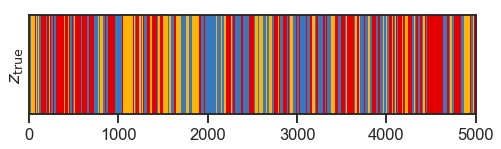

In [8]:
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(zs[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

### Transitions (in a shorter time window)

In [9]:
dur=200
st_t=650
end_t=st_t+dur

([], <a list of 0 Text yticklabel objects>)

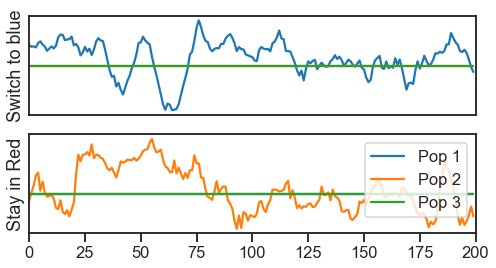

In [10]:
plt.figure(figsize=(8, 4))

j=0

plt.subplot(211)
for g in range(K):
    plt.plot(np.dot(xs[st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],true_slds.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
plt.ylabel('Switch to blue')
plt.xticks([])
plt.yticks([])

j=1
plt.subplot(212)
for g in range(K):
    plt.plot(np.dot(xs[st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],true_slds.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
plt.ylabel('Stay in Red')
plt.legend(['Pop 1','Pop 2','Pop 3'])
plt.yticks([])

### Latents and spikes for an example population

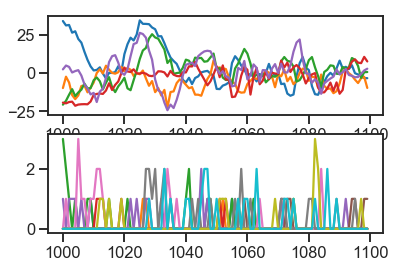

In [11]:
time_example=np.arange(1000,1100)
plt.figure()
plt.subplot(211)
plt.plot(time_example,xs[time_example,:num_per_gr])
plt.subplot(212)
plt.plot(time_example,ys[time_example,:10])


## Fit model to data

In [26]:
sro_trans=StickyRecurrentOnlyTransitions(K=K,D=np.sum(D_vec), l2_penalty_similarity=1000)

lds_ar = ssm.SLDS(N=np.sum(N_vec),K=K,D=np.sum(D_vec),
             dynamics="gaussian",
             emissions=poiss_comp_emissions,
             transitions=sro_trans,
             dynamics_kwargs=dict(l2_penalty_A=100))

# lds_ar = ssm.SLDS(N=np.sum(N_vec),K=K,D=np.sum(D_vec),
#              dynamics="gaussian",
#              emissions=poiss_comp_emissions,
#              dynamics_kwargs=dict(l2_penalty_A=100))

lds_ar.initialize(ys,init='ar_clust', t_win=10, t_gap=4)

q_elbos_ar, q_ar = lds_ar.fit(ys, method="laplace_em",
                               variational_posterior="structured_meanfield", continuous_optimizer='newton',
                               initialize=False, num_iters=40, alpha=.25)

Initializing with an ARHMM using 25 steps of EM.
initialization method is: ar_clust
t_win: 10
t_gap: 4


init



In [33]:
lds_ar.transitions.s

array([-0.46426889,  0.11608741, -1.287167  ])

In [34]:
lds_ar.transitions.r

array([-0.56236225,  0.07320953, -1.40513681])

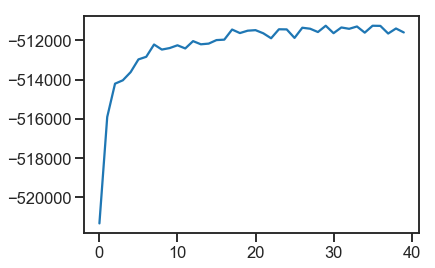

In [27]:
plt.plot(q_elbos_ar[1:])

## Plot results

### Discrete states

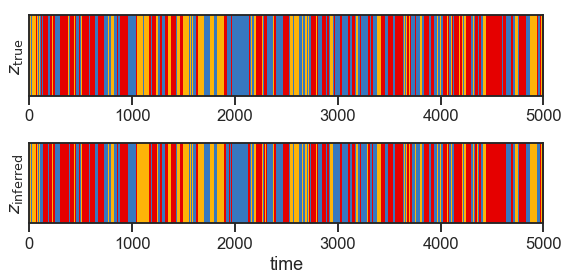

In [28]:
z_inferred=lds_ar.most_likely_states(q_ar.mean_continuous_states[0],ys)
lds_ar.permute(find_permutation(zs, z_inferred))
z_inferred2=lds_ar.most_likely_states(q_ar.mean_continuous_states[0],ys)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(zs[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(z_inferred2[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

In [29]:
np.mean(zs==z_inferred2)

0.9596

### Shorter time window

([], <a list of 0 Text yticklabel objects>)

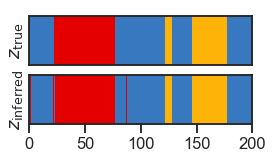

In [30]:


plt.figure(figsize=(4, 2))
plt.subplot(211)
plt.imshow(zs[None,st_t:end_t], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, dur)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])
plt.xticks([])

plt.subplot(212)
plt.imshow(z_inferred2[None,st_t:end_t], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, dur)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])

### Dynamics

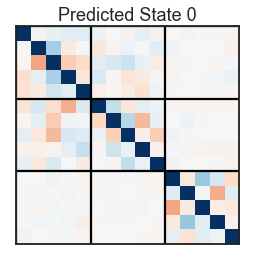

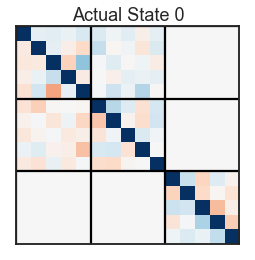

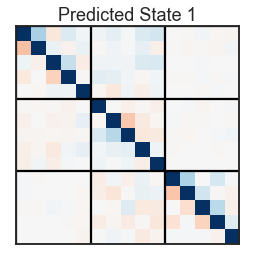

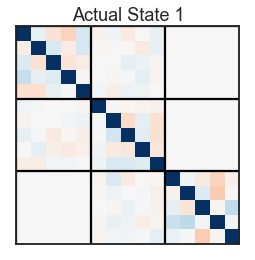

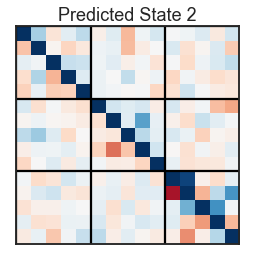

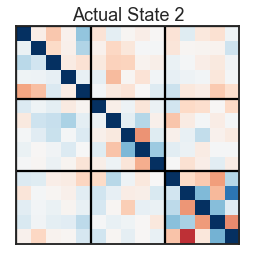

In [31]:
for k in range(K):
    plt.figure(figsize=(4,4))
    plt.imshow(lds_ar.dynamics.As[k], aspect='auto', interpolation="none", vmin=-.5, vmax=.5, cmap='RdBu')
    offset=-.5
    for nf in D_vec:        
        plt.plot([-0.5, D-0.5], [offset, offset], '-k')
        plt.plot([offset, offset], [-0.5, D-0.5], '-k')
        offset += nf
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted State '+str(k))
#     plt.savefig(folder+'dyn_est'+str(k)+'.pdf')
    
    plt.figure(figsize=(4,4))
    plt.imshow(true_slds.dynamics.As[k], aspect='auto', interpolation="none", vmin=-.5, vmax=.5, cmap='RdBu')
    offset=-.5
    for nf in D_vec:        
        plt.plot([-0.5, D-0.5], [offset, offset], '-k')
        plt.plot([offset, offset], [-0.5, D-0.5], '-k')
        offset += nf
    plt.xticks([])
    plt.yticks([])
    plt.title('Actual State '+str(k))

#     plt.savefig(folder+'dyn_true'+str(k)+'.pdf')

### Transitions

([], <a list of 0 Text yticklabel objects>)

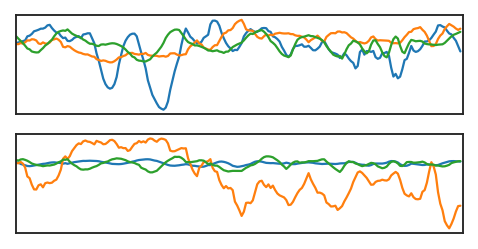

In [32]:
plt.figure(figsize=(8, 4))

j=0

plt.subplot(211)
for g in range(K):
    plt.plot(np.dot(q_ar.mean_continuous_states[0][st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],lds_ar.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
# plt.ylabel('Switch to blue')
plt.xticks([])
plt.yticks([])

j=1
plt.subplot(212)
for g in range(K):
    plt.plot(np.dot(q_ar.mean_continuous_states[0][st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],lds_ar.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
# plt.ylabel('Stay in Red')
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

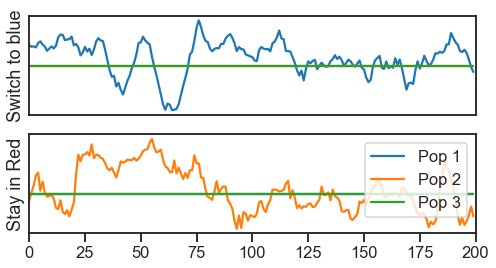

In [19]:
plt.figure(figsize=(8, 4))

j=0

plt.subplot(211)
for g in range(K):
    plt.plot(np.dot(xs[st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],true_slds.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
plt.ylabel('Switch to blue')
plt.xticks([])
plt.yticks([])

j=1
plt.subplot(212)
for g in range(K):
    plt.plot(np.dot(xs[st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],true_slds.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
plt.ylabel('Stay in Red')
plt.legend(['Pop 1','Pop 2','Pop 3'])
plt.yticks([])

In [20]:
stop

NameError: name 'stop' is not defined

In [ ]:
# plt.figure(figsize=(8, 4))
# plt.subplot(211)
# plt.imshow(zs[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
# plt.xlim(0, t_end)
# plt.ylabel("$z_{\\mathrm{true}}$")
# plt.yticks([])

In [ ]:
plt.plot(zs[400:500])

In [ ]:
for k in range(K):
    plt.figure()    
    plt.imshow(true_slds.dynamics.As[k], aspect='auto', interpolation="none", vmin=-1, vmax=1, cmap='RdBu')

In [ ]:
def get_gr_norms(A):
    AI=A-np.identity(D)
    norms=np.zeros([num_gr,num_gr])
    for i in range(num_gr):
        for j in range(num_gr):
            norms[i,j]=np.linalg.norm(AI[D_vec_cumsum[i]:D_vec_cumsum[i+1],D_vec_cumsum[j]:D_vec_cumsum[j+1]])
    return norms

In [ ]:
def get_gr_means(A):
    AI=A-np.identity(D)
    norms=np.zeros([num_gr,num_gr])
    for i in range(num_gr):
        for j in range(num_gr):
            norms[i,j]=np.mean(np.abs(AI[D_vec_cumsum[i]:D_vec_cumsum[i+1],D_vec_cumsum[j]:D_vec_cumsum[j+1]]))
    return norms

In [ ]:
# plt.figure(figsize=(8, 4))
# plt.subplot(211)
# plt.imshow(zs[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
# plt.xlim(0, t_end)
# plt.ylabel("$z_{\\mathrm{true}}$")
# plt.yticks([])

In [ ]:
# lds_ar.transitions.Rs

In [ ]:
# lds_ar.transitions.R2s

In [ ]:
np.mean(ys)

In [ ]:
np.mean(ys,axis=0)/.025

In [ ]:
# np.median(np.mean(ys,axis=0)/.025)

In [ ]:
plt.plot(xs[:100])

In [ ]:
plt.plot(xs[:500])

In [ ]:
np.mean(np.abs(xs[1:]-xs[:-1]))

In [ ]:
# tmp=np.mean(relu(np.dot(true_slds.emissions.Cs[0],xs.T)+.1*true_slds.emissions.ds[0][:,None]).T)
# mult=.4/tmp
# lams=relu(mult*np.dot(true_slds.emissions.Cs[0],xs.T)+.1*true_slds.emissions.ds[0][:,None]).T
# ys=np.random.poisson(lams)

In [ ]:
# np.mean(lams)

In [ ]:
# tmp=np.mean(relu(np.dot(true_slds.emissions.Cs[0],xs.T)+.1*true_slds.emissions.ds[0][:,None]).T)

In [ ]:
# np.mean(lams)

In [ ]:
# np.mean((np.dot(true_slds.emissions.Cs[0],xs.T)+.1*true_slds.emissions.ds[0][:,None]).T)

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(zs[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

In [ ]:
plt.plot(zs[1000:1100])

In [ ]:
plt.plot(q_elbos_ar[1:])

In [ ]:
z_inferred=lds_ar.most_likely_states(q_ar.mean_continuous_states[0],ys)

lds_ar.permute(find_permutation(zs, z_inferred))
# Plot the true and inferred discrete states
z_inferred2=lds_ar.most_likely_states(q_ar.mean_continuous_states[0],ys)



plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(zs[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(z_inferred2[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

In [ ]:
np.mean(zs==z_inferred2)

In [ ]:
for k in range(K):
    norms=get_gr_norms(true_slds.dynamics.As[k])**2
    norm_normalized=norms/np.max(norms,axis=1)[:,None]
    print(norm_normalized)
    print(np.mean((norm_normalized>.1)==A_masks[k]))

In [ ]:
for k in range(K):
    norms=get_gr_norms(true_slds.dynamics.As[k])
    norm_normalized=norms/np.max(norms,axis=1)[:,None]
    print(norm_normalized)

In [ ]:
for k in range(K):
    norms=get_gr_norms(true_slds.dynamics.As[k])**2
    norm_normalized=norms/np.max(norms,axis=1)[:,None]
    print(norm_normalized)
    print(np.mean((norm_normalized>.1)==A_masks[k]))

In [ ]:
for k in range(K):
    norms=get_gr_means(true_slds.dynamics.As[k])
#     norm_normalized=norms/np.max(norms,axis=1)[:,None]
    print(norms)
#     print(np.mean((norm_normalized>.1)==A_masks[k]))

In [ ]:
for k in range(K):
    norms=get_gr_means(lds_ar.dynamics.As[k])
#     norm_normalized=norms/np.max(norms,axis=1)[:,None]
    print(norms)
#     print(np.mean((norm_normalized>.1)==A_masks[k]))

In [ ]:
alphas

In [ ]:
# for k in range(K):
#     norms=get_gr_norms(lds_ar.dynamics.As[k])
#     norm_normalized=norms/np.max(norms,axis=1)[:,None]
#     print(norm_normalized)
#     print(np.mean((norm_normalized>.1)==A_masks[k]))

In [ ]:
for k in range(K):
    norms=get_gr_norms(lds_ar.dynamics.As[k])**2
    norm_normalized=norms/np.max(norms,axis=1)[:,None]
    print(norm_normalized)
    print(np.mean((norm_normalized>.1)==A_masks[k]))

In [ ]:
stdevs=np.std(np.vstack(q_ar.mean_continuous_states),axis=0)

for k in range(K):
    norms=get_gr_norms(lds_ar.dynamics.As[k]*stdevs[:,None]/stdevs[:,None].T)**2
    norm_normalized=norms/np.max(norms,axis=1)[:,None]
    print(norm_normalized)
    print(np.mean((norm_normalized>.1)==A_masks[k]))


In [ ]:
# def get_gr_norms2(A):
#     AI=A
#     norms=np.zeros([num_gr,num_gr])
#     for i in range(num_gr):
#         for j in range(num_gr):
#             norms[i,j]=np.linalg.norm(AI[D_vec_cumsum[i]:D_vec_cumsum[i+1],D_vec_cumsum[j]:D_vec_cumsum[j+1]])
#     return norms

In [ ]:
# stdevs=np.std(np.vstack(q_ar.mean_continuous_states),axis=0)
# # stdevs=np.mean(np.abs(np.vstack(q_lem.mean_continuous_states)),axis=0)

# A_adjust=[]
# for k in range(K):
#     A_adjust.append((lds_ar.dynamics.As[k]-np.identity(D))*stdevs)
#     A_adjust.append((lds_ar.dynamics.As[k]-np.identity(D))*stdevs)
    
# for k in range(K):
#     norms=get_gr_norms2(A_adjust[k])**2
#     norm_normalized=norms/np.max(norms,axis=1)[:,None]
# #     print(norms)
#     print(norm_normalized)
#     print(np.mean((norm_normalized>.1)==A_masks[k]))

In [ ]:
for k in range(K):
    plt.figure()
    plt.imshow(lds_ar.dynamics.As[k], aspect='auto', interpolation="none", vmin=-.5, vmax=.5, cmap='RdBu')
    
    plt.figure()
    plt.imshow(true_slds.dynamics.As[k], aspect='auto', interpolation="none", vmin=-.5, vmax=.5, cmap='RdBu')
    

In [ ]:
z_inferred2

In [ ]:
trans_time_list=[]
for i in range(K):
    tt=[]
    for j in range(K):       
        tt.append(np.where((z_inferred2[:-1]==i) * (z_inferred2[1:]==j))[0])
    trans_time_list.append(tt)
    
# trans_time_list=[]
# for i in range(K):
#     tt=[]
#     for j in range(K):       
#         tt.append(np.where((zs[:-1]==i) * (zs[1:]==j))[0])
#     trans_time_list.append(tt)

In [ ]:
num_trans=np.zeros([K,K])
for i in range(K):
    for j in range(K):
        num_trans[i,j]=trans_time_list[i][j].shape[0]

In [ ]:
num_trans

In [ ]:
num_trans

In [ ]:
i=1
j=0
np.dot(q_ar.mean_continuous_states[0][trans_time_list[i][j],:],lds_ar.transitions.Rs[j].T)

In [ ]:
g=0
i=1
j=0
np.dot(q_ar.mean_continuous_states[0][trans_time_list[i][j],D_vec_cumsum[g]:D_vec_cumsum[g+1]],lds_ar.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T)

In [ ]:
g=2
i=2
j=0
np.mean(np.exp(np.dot(q_ar.mean_continuous_states[0][trans_time_list[i][j],D_vec_cumsum[g]:D_vec_cumsum[g+1]],lds_ar.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T)))

In [ ]:
val_vals=[]
for j in range(K):
    vals=[]
    for g in range(num_gr):
        val=0
        for i in range(K):
            if i!=j:
                val=val+np.mean(np.exp(np.dot(q_ar.mean_continuous_states[0][trans_time_list[i][j],D_vec_cumsum[g]:D_vec_cumsum[g+1]],lds_ar.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T)))
        vals.append(val)
    val_vals.append(vals)

In [ ]:
val_vals

In [ ]:
val_vals2=[]
for j in range(K):
    vals=[]
    for g in range(num_gr):
        val=0
        for i in range(K):
            if i==j:
                val=val+np.mean(np.exp(np.dot(q_ar.mean_continuous_states[0][trans_time_list[i][j],D_vec_cumsum[g]:D_vec_cumsum[g+1]],lds_ar.transitions.R2s[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T)))
        vals.append(val)
    val_vals2.append(vals)

In [ ]:
val_vals2

In [ ]:
np.mean(np.argmax(np.array(val_vals),axis=1)==np.array([0,1,2]))

In [ ]:
g=2
i=2
j=2
np.mean(np.exp(np.dot(q_ar.mean_continuous_states[0][trans_time_list[i][j],D_vec_cumsum[g]:D_vec_cumsum[g+1]],lds_ar.transitions.R2s[i,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T)))

In [ ]:
lds_ar.transitions.Rs

In [ ]:
lds_ar.transitions.R2s

In [ ]:
# z_exp=lds_ar.most_likely_states(q_ar.mean_continuous_states[0],ys)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
enc=OneHotEncoder(sparse=False)
z_exp=enc.fit_transform(z_inferred2[:,None]).T

In [ ]:
# exp_diff=np.abs(z_exp[0][1:]-z_exp[0][:-1])
exp_diff=np.abs(z_exp[0][1:]-z_exp[0][:-1])

In [ ]:
z_exp

In [ ]:
i=0
exp_diff=np.abs(z_exp[i,1:]-z_exp[i,:-1])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [ ]:
logr=LogisticRegression()
logr.fit(q_ar.mean_continuous_states[0][:-1],exp_diff)


In [ ]:
logr.coef_

In [ ]:
lds_ar.transitions.Rs[0]

In [ ]:
lr=LinearRegression()
exp_diff2=1-np.abs(exp_diff-.99)
lr.fit(q_ar.mean_continuous_states[0][:-1],exp_diff2)

In [ ]:
lr.coef_

In [ ]:
exp_diff.shape

In [ ]:
true_slds.transitions.R2s

In [ ]:
true_slds.transitions.Rs

In [ ]:
np.dot(q_ar.mean_continuous_states[0][trans_time_list[i][j],:],lds_ar.transitions.Rs[2].T)

In [ ]:
lds_ar.transitions.log_Ps

In [ ]:
j=0
np.dot(lds_ar.transitions.Rs[j],

In [ ]:
trans_time_list[0][0]

In [ ]:
stop

In [ ]:
z_inferred2[1:].shape

In [ ]:
dyn_ll=lds_ar.dynamics.log_likelihoods(q_ar.mean_continuous_states[0],np.zeros([q_ar.mean_continuous_states[0].shape[0],1]),np.ones(q_ar.mean_continuous_states[0].shape),None)

In [ ]:
for k in range(3):
    inc=(z_inferred2[1:]==k)
    inc_idx=np.where(inc)[0]+1
    print(np.sum(dyn_ll[inc_idx],axis=0))

In [ ]:
lds_ar.emissions.log_likelihoods(ys,np.zeros([ys.shape[0],0]),np.ones(ys.shape),None,q_ar.mean_continuous_states[0])[:10]

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [ ]:
num_cv_folds=2
kf = KFold(n_splits=num_cv_folds)
####1. REFIT A WITH MASK####
#with ridge regression?

####2. Do CV Loop #####

##Get indices of discrete state

k=0
inc=(z_inferred2[1:]==k)
inc_idx=np.where(inc)[0]+1
X=q_ar.mean_continuous_states[0][inc_idx-1]
Y=q_ar.mean_continuous_states[0][inc_idx]
# inc=(z_inferred2[:-1]==k)
# inc_idx=np.where(inc)[0]
# X=q_ar.mean_continuous_states[0][inc_idx]
# Y=q_ar.mean_continuous_states[0][inc_idx+1]

# for train_index, test_index in kf.split(X):
for test_index, train_index in kf.split(X):
    X_train=X[train_index]
    X_test=X[test_index]
    Y_train_all=Y[train_index]
    Y_test_all=Y[test_index]
    
    ys_act=ys[inc_idx,:][test_index]


    lr0=LinearRegression()
    lr0.fit(X_train,Y_train_all)
    Ypred_all=lr0.predict(X_test)
    
    print("all_ll",np.sum(lds_ar.emissions.log_likelihoods(ys_act,np.zeros([ys_act.shape[0],0]),np.ones([ys_act.shape[0],ys.shape[1]]),None,Ypred_all)))
    
    g1=1
    Y_train=Y_train_all[:,D_vec_cumsum[g1]:D_vec_cumsum[g1+1]]
    Y_test=Y_test_all[:,D_vec_cumsum[g1]:D_vec_cumsum[g1+1]]
    
    lr=LinearRegression()
    lr.fit(X_train,Y_train)
    print("all",lr.score(X_test,Y_test))

    
    g2=0
    include=np.arange(D)
    include=np.delete(include,np.arange(D_vec_cumsum[g2],D_vec_cumsum[g2+1]))
#     g2_2=1
#     include=np.delete(include,np.arange(D_vec_cumsum[g2_2],D_vec_cumsum[g2_2+1]))
    
    lr2=LinearRegression()
    lr2.fit(X_train[:,include],Y_train)
    print(g2,lr2.score(X_test[:,include],Y_test))
    
    
    Ypred=np.copy(Ypred_all)
    Ypred[:,D_vec_cumsum[g1]:D_vec_cumsum[g1+1]]=lr2.predict(X_test[:,include])
    print("new_ll",np.sum(lds_ar.emissions.log_likelihoods(ys_act,np.zeros([ys_act.shape[0],0]),np.ones([ys_act.shape[0],ys.shape[1]]),None,Ypred)))
    print('')
    
    
    
# -Split each discrete state into CV folds
# -Fit new A based on threshold (one at a time?), using that training data
# -Determine testset:
#     1) Dynamics SSE
#     2) Dynamics LL
#     3) Emissions LL

## Plots

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(zs[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(z_inferred2[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

In [ ]:
D_vec

In [ ]:
for k in range(K):
    plt.figure(figsize=(4,4))
    plt.imshow(lds_ar.dynamics.As[k], aspect='auto', interpolation="none", vmin=-.5, vmax=.5, cmap='RdBu')
    offset=-.5
    for nf in D_vec:        
        plt.plot([-0.5, D-0.5], [offset, offset], '-k')
        plt.plot([offset, offset], [-0.5, D-0.5], '-k')
        offset += nf
    plt.xticks([])
    plt.yticks([])
#     plt.savefig(folder+'dyn_est'+str(k)+'.pdf')
    
    plt.figure(figsize=(4,4))
    plt.imshow(true_slds.dynamics.As[k], aspect='auto', interpolation="none", vmin=-.5, vmax=.5, cmap='RdBu')
    offset=-.5
    for nf in D_vec:        
        plt.plot([-0.5, D-0.5], [offset, offset], '-k')
        plt.plot([offset, offset], [-0.5, D-0.5], '-k')
        offset += nf
    plt.xticks([])
    plt.yticks([])
#     plt.savefig(folder+'dyn_true'+str(k)+'.pdf')

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(zs[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(z_inferred2[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

In [ ]:
q_ar.mean_continuous_states[0][trans_time_list[i][j],D_vec_cumsum[g]:D_vec_cumsum[g+1]],lds_ar.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T)))

In [ ]:
folder='/Users/jig289/Dropbox/PD/neurips_figs/'

In [ ]:
folder='/Users/jig289/Dropbox/PD/neurips_figs/'
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42


In [ ]:
dur=200
st_t=650 #2050 #450?
end_t=st_t+dur

plt.figure(figsize=(4, 2))
plt.subplot(211)
plt.imshow(zs[None,st_t:end_t], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, dur)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])
plt.xticks([])

plt.subplot(212)
plt.imshow(z_inferred2[None,st_t:end_t], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, dur)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])

# plt.xlabel("time")

# plt.tight_layout()
# plt.savefig(folder+'sim_disc_states.pdf')

In [ ]:
plt.figure(figsize=(8, 4))

j=0

plt.subplot(211)
for g in range(K):
    plt.plot(np.dot(xs[st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],true_slds.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
plt.ylabel('Switch to blue')
plt.xticks([])
plt.yticks([])

j=1
plt.subplot(212)
for g in range(K):
    plt.plot(np.dot(xs[st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],true_slds.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
plt.ylabel('Stay in Red')
plt.legend(['Pop 1','Pop 2','Pop 3'])
plt.yticks([])

# plt.subplot(313)
# for g in range(K):
#     plt.plot(np.dot(xs[st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],true_slds.transitions.R2s[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
# plt.xlim(0, dur)

# plt.savefig(folder+'sim_trans.pdf')

In [ ]:
plt.figure(figsize=(8, 4))

j=0

plt.subplot(211)
for g in range(K):
    plt.plot(np.dot(q_ar.mean_continuous_states[0][st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],lds_ar.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
# plt.ylabel('Switch to blue')
plt.xticks([])
plt.yticks([])

j=1
plt.subplot(212)
for g in range(K):
    plt.plot(np.dot(q_ar.mean_continuous_states[0][st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],lds_ar.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
# plt.ylabel('Stay in Red')
plt.xticks([])
plt.yticks([])
# plt.legend(['Pop 1','Pop 2','Pop 3'],loc='right')

# plt.subplot(313)
# for g in range(K):
#     plt.plot(np.dot(q_ar.mean_continuous_states[0][st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],lds_ar.transitions.R2s[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
# plt.xlim(0, dur)
# plt.savefig(folder+'sim_trans_est.pdf')

# Test set

In [ ]:
lds_ar2=copy.deepcopy(lds_ar)
# lds_ar2.dynamics.bs=true_slds.dynamics.bs
lds_ar2.dynamics.As=true_slds.dynamics.As

In [ ]:
z_inferred_test=lds_ar.most_likely_states(tmp[1].mean_continuous_states[0],ys_test)

# z_inferred_test=lds_ar.most_likely_states(xs_test,ys_test)

# z_inferred_test=true_slds.most_likely_states(tmp[1].mean_continuous_states[0],ys_test)
# z_inferred_test=lds_ar2.most_likely_states(tmp[1].mean_continuous_states[0],ys_test)


lds_ar.permute(find_permutation(zs_test, z_inferred_test))
# Plot the true and inferred discrete states
z_inferred_test2=lds_ar.most_likely_states(tmp[1].mean_continuous_states[0],ys_test)
# z_inferred_test2=lds_ar.most_likely_states(xs_test,ys_test)


In [ ]:
z_inferred_test=lds_sp.most_likely_states(tmp[1].mean_continuous_states[0],ys_test)
lds_sp.permute(find_permutation(zs_test, z_inferred_test))
z_inferred_test2=lds_sp.most_likely_states(tmp[1].mean_continuous_states[0],ys_test)


In [ ]:
np.mean(z_inferred_test==zs_test)

In [ ]:
np.mean(z_inferred_test2==zs_test)

In [ ]:
z_inferred_test3=np.argmax(tmp[1].mean_discrete_states[0],axis=1)

In [ ]:
np.mean(z_inferred_test3==zs_test)

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(zs_test[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(z_inferred_test2[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

In [ ]:

####1. REFIT A WITH MASK####
#with ridge regression?

##Get indices of discrete state

k=1

inc=(z_inferred2[1:]==k)
inc_idx=np.where(inc)[0]+1
X_train=q_ar.mean_continuous_states[0][inc_idx-1]
Y_train_all=q_ar.mean_continuous_states[0][inc_idx]


inc=(z_inferred_test3[1:]==k)
inc_idx=np.where(inc)[0]+1
X_test=tmp[1].mean_continuous_states[0][inc_idx-1]
Y_test_all=tmp[1].mean_continuous_states[0][inc_idx]



    
ys_act=ys_test[inc_idx,:]


lr0=LinearRegression()
lr0.fit(X_train,Y_train_all)
Ypred_all=lr0.predict(X_test)

print("all_ll",np.sum(lds_ar.emissions.log_likelihoods(ys_act,np.zeros([ys_act.shape[0],0]),np.ones([ys_act.shape[0],ys_act.shape[1]]),None,Ypred_all)))

g1=0
Y_train=Y_train_all[:,D_vec_cumsum[g1]:D_vec_cumsum[g1+1]]
Y_test=Y_test_all[:,D_vec_cumsum[g1]:D_vec_cumsum[g1+1]]

lr=LinearRegression()
lr.fit(X_train,Y_train)
print("all",lr.score(X_test,Y_test))


g2=1
include=np.arange(D)
include=np.delete(include,np.arange(D_vec_cumsum[g2],D_vec_cumsum[g2+1]))
#     g2_2=1
#     include=np.delete(include,np.arange(D_vec_cumsum[g2_2],D_vec_cumsum[g2_2+1]))

lr2=LinearRegression()
lr2.fit(X_train[:,include],Y_train)
print(g2,lr2.score(X_test[:,include],Y_test))


Ypred=np.copy(Ypred_all)
Ypred[:,D_vec_cumsum[g1]:D_vec_cumsum[g1+1]]=lr2.predict(X_test[:,include])
print("new_ll",np.sum(lds_ar.emissions.log_likelihoods(ys_act,np.zeros([ys_act.shape[0],0]),np.ones([ys_act.shape[0],ys_act.shape[1]]),None,Ypred)))
print('')

    


In [ ]:
for k in range(K):
    plt.figure()
    plt.imshow(lds_ar.dynamics.As[k], aspect='auto', interpolation="none", vmin=-1, vmax=1, cmap='RdBu')
    plt.colorbar()
    
for k in range(K):
    plt.figure()
    plt.imshow(true_slds.dynamics.As[k], aspect='auto', interpolation="none", vmin=-1, vmax=1, cmap='RdBu')
    plt.colorbar()

In [ ]:
for k in range(K):
    plt.figure()
    plt.imshow(true_slds.dynamics.As[k], aspect='auto', interpolation="none", vmin=-1, vmax=1, cmap='RdBu')
    plt.colorbar()

In [ ]:
np.diag(lds_ar.dynamics.As[1])

In [ ]:
np.diag(true_slds.dynamics.As[1])

In [ ]:
np.diag(lds_ar.dynamics.As[0])

In [ ]:
np.diag(true_slds.dynamics.As[0])

In [ ]:
true_slds.dynamics.bs[0]

In [ ]:
lds_ar.dynamics.bs[0]

In [ ]:
true_slds.dynamics.bs[1]

In [ ]:
lds_ar.dynamics.bs[1]

In [ ]:
np.linalg.eigvals(lds_ar.dynamics.As[1])

In [ ]:
np.linalg.eigvals(true_slds.dynamics.As[1])

In [ ]:
lds_ar.transitions.transition_matrix

In [ ]:
true_slds.transitions.transition_matrix

In [ ]:
ys_act.shape

In [ ]:
Ypred_all.shape

In [ ]:
%debug

In [ ]:
lr0.score(X_train,Y_train_all)

In [ ]:
Ypred=lr0.predict(X_test)

In [ ]:
ys[inc_idx,:]

In [ ]:
Ypred.shape

In [ ]:
ys_act.shape

In [ ]:
ys_act=ys[inc_idx,:][test_index]
np.sum(lds_ar.emissions.log_likelihoods(ys_act,np.zeros([ys_act.shape[0],0]),np.ones([ys_act.shape[0],ys.shape[1]]),None,Ypred))

In [ ]:
ys.shape[0]

In [ ]:
for k in range(3):
    pred=np.dot(q_ar.mean_continuous_states[0],lds_ar.dynamics.As[k].T)[:-1]
    print(lds_ar.emissions.log_likelihoods(ys[1:],np.zeros([ys.shape[0]-1,0]),np.ones([ys.shape[0]-1,ys.shape[1]]),None,pred)[:10])

In [ ]:
import copy

In [ ]:
lds_copy=copy.deepcopy(lds_ar)

In [ ]:
lds_copy.dynamics.As[k]=lr0.coef_
lds_copy.dynamics.bs[k]=lr0.intercept_


In [ ]:
plt.imshow(lr0.coef_, aspect='auto', interpolation="none", vmin=-1, vmax=1, cmap='RdBu')

In [ ]:
lr0.intercept_

In [ ]:
plt.imshow(lds_ar.dynamics.As[1], aspect='auto', interpolation="none", vmin=-1, vmax=1, cmap='RdBu')


In [ ]:
all 0.895836728672041
0 0.9143844867474444
all 0.8914028196908788
0 0.9243625054437348
all 0.819334440087855
0 0.9189726698972118
all 0.869874134719664
0 0.884977863712692

In [ ]:
lr.score(X_test,Y_test)

In [ ]:
lr.score(X_train,Y_train)

In [ ]:
Y_train.shape

In [ ]:
X_test.shape

In [ ]:
lds_ar.dynamics.log_likelihoods(q_ar.mean_continuous_states[0],np.zeros([q_ar.mean_continuous_states[0].shape[0],1]),np.ones(q_ar.mean_continuous_states[0].shape),None)[:10]

In [ ]:
lds_ar.emissions.log_likelihoods(ys,np.zeros([ys.shape[0],0]),np.ones(ys.shape),None,q_ar.mean_continuous_states[0])[:10]

In [ ]:
pred0=np.dot(q_ar.mean_continuous_states[0],lds_ar.dynamics.As[0].T)[:-1]
lds_ar.emissions.log_likelihoods(ys[:-1],np.zeros([ys.shape[0]-1,0]),np.ones([ys.shape[0]-1,ys.shape[1]]),None,pred0)[:10]

In [ ]:
pred1=np.dot(q_ar.mean_continuous_states[0],lds_ar.dynamics.As[1].T)[:-1]
lds_ar.emissions.log_likelihoods(ys[:-1],np.zeros([ys.shape[0]-1,0]),np.ones([ys.shape[0]-1,ys.shape[1]]),None,pred1)[:10]

In [ ]:
for k in range(3):
    pred=np.dot(q_ar.mean_continuous_states[0],lds_ar.dynamics.As[k].T)[:-1]
    print(lds_ar.emissions.log_likelihoods(ys[1:],np.zeros([ys.shape[0]-1,0]),np.ones([ys.shape[0]-1,ys.shape[1]]),None,pred)[:10])

In [ ]:
z_inferred=lds_sp.most_likely_states(q_sp.mean_continuous_states[0],ys)

lds_sp.permute(find_permutation(zs, z_inferred))
# Plot the true and inferred discrete states
z_inferred2=lds_sp.most_likely_states(q_sp.mean_continuous_states[0],ys)




plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(zs[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(z_inferred2[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

In [ ]:
np.mean(zs==z_inferred2)

In [ ]:
for k in range(K):

    print(np.mean(lds_sp.dynamics.As_mask[k]==A_masks[k]))
    

In [ ]:
for k in range(K):
    plt.figure()
    plt.imshow(true_slds.dynamics.As[k], aspect='auto', interpolation="none", vmin=-1, vmax=1, cmap='RdBu')
    plt.colorbar()

In [ ]:
for k in range(K):
    plt.figure()
    plt.imshow(lds_ar.dynamics.As[k], aspect='auto', interpolation="none", vmin=-1, vmax=1, cmap='RdBu')
    plt.colorbar()

In [ ]:
for k in range(K):
    plt.figure()
    plt.imshow(lds_sp.dynamics.As[k], aspect='auto', interpolation="none", vmin=-1, vmax=1, cmap='RdBu')
    plt.colorbar()

In [ ]:
np.diag(lds_ar.dynamics.As[2])

In [ ]:
np.diag(true_slds.dynamics.As[2])

In [ ]:
stop

In [ ]:
output=lds_ar.approximate_posterior(ys)

In [ ]:
output

In [ ]:
output[1].mean_continuous_states[0].shape

In [ ]:
plt.plot(output[1].mean_continuous_states[0][:100,:2])

In [ ]:
plt.plot(output[1].mean_continuous_states[0][:100,:2])

In [ ]:
output=lds_ar.approximate_posterior(ys,num_iters=50,alpha=0)

In [ ]:
output[0] #alpha1

In [ ]:
output[0] #alpha.75

In [ ]:
output[0] #alpha.5

In [ ]:
output[0] #alpha.25

In [ ]:
output[0] #alpha0

In [ ]:
# %debug

In [ ]:
# %debug

In [ ]:
np.mean(A_acc_ar)

In [ ]:
print("ar_acc",np.mean(A_acc_ar))
print("sp_acc",np.mean(A_acc_sp))
print("ar_ll",np.mean(ll_ar))
print("sp_ll",np.mean(ll_sp))

In [ ]:
# ar_acc 0.775
# ar_diag_acc 0.765

# sp_acc 0.736

In [ ]:
stop
# sp_ll -373584.23291210894
# sp_ll -234759.7301952812



In [ ]:
plt.plot(xs[0][:200])

In [ ]:
hmm_sp.observations.As_mask

In [ ]:
A_mask

In [ ]:
plt.imshow(A, aspect='auto', interpolation="none", vmin=-.3, vmax=.3, cmap='RdBu')
plt.colorbar()

In [ ]:
plt.imshow(true_hmm.observations.As[0], aspect='auto', interpolation="none", vmin=-.3, vmax=.3, cmap='RdBu')
plt.colorbar()

In [ ]:
plt.imshow(hmm_ar.observations.As[0], aspect='auto', interpolation="none", vmin=-.3, vmax=.3, cmap='RdBu')
plt.colorbar()

In [ ]:
plt.imshow(hmm_ar.observations.As[0], aspect='auto', interpolation="none", vmin=-.5, vmax=.5, cmap='RdBu')
plt.colorbar()

In [ ]:
norms=get_gr_norms(hmm_ar.observations.As[0])**2
norm_normalized=norms/np.max(norms)

In [ ]:
norm_normalized

In [ ]:
A_masks[0]

In [ ]:
print("ar_acc",np.mean(A_acc_ar))
print("sp_acc",np.mean(A_acc_sp))
print("ar_acc",np.mean(ll_ar))
print("sp_acc",np.mean(ll_sp))

In [ ]:
print("ar_acc",np.mean(A_acc_ar))
print("sp_acc",np.mean(A_acc_sp))
print("ar_acc",np.mean(ll_ar))
print("sp_acc",np.mean(ll_sp))

In [ ]:
print("ar_acc",np.mean(A_acc_ar))
print("sp_acc",np.mean(A_acc_sp))
print("ar_acc",np.mean(ll_ar))
print("sp_acc",np.mean(ll_sp))

In [ ]:
print("ar_acc",np.mean(A_acc_ar))
print("sp_acc",np.mean(A_acc_sp))
print("ar_acc",np.mean(ll_ar))
print("sp_acc",np.mean(ll_sp))

In [ ]:
print("ar_acc",np.mean(A_acc_ar))
print("sp_acc",np.mean(A_acc_sp))
print("ar_acc",np.mean(ll_ar))
print("sp_acc",np.mean(ll_sp))

In [ ]:
#prior_precision_A=1

In [ ]:
np.mean(1-A_acc_ar)

In [ ]:
np.mean(A_acc_sp)

In [ ]:
np.mean(ll_ar)

In [ ]:
np.mean(ll_sp)

In [ ]:
from itertools import product


In [ ]:

B_in=3
assignments = np.array(list(product([0, 1], repeat=B_in)))
log_probs = np.zeros(2**B_in)
# for ind, zk in enumerate(assignments):
#     # Expand the binary mask and pad with an extra one for the intercept
#     z = np.concatenate([np.kron(zk, np.ones(S_in)), np.ones(1)])
#     for i in range(k * S_out, (k + 1) * S_out):
#         J = J0 + 1/sigmasq[i] * big_xxT * np.outer(z, z)

In [ ]:
assignments

In [ ]:
for ind, zk in enumerate(assignments):
    zk2=np.ones(4)
    zk2[np.delete(np.arange(0,4),2)]=zk
#     print(ind,zk,zk2)
    print(np.concatenate([np.kron(zk2, np.ones(3)), np.ones(1)]))

In [ ]:
list(product([0, 1], repeat=2))

In [ ]:
np.array(list(product([0, 1], repeat=B_in)))

In [ ]:
# for i in range(3):
#     for j i range(3):
#     print(i,j)

# HMM

In [ ]:


npr.seed(0)

# import seaborn as sns
# sns.set_style("white")
# sns.set_context("talk")

# from ssm.variational import SLDSMeanFieldVariationalPosterior, SLDSTriDiagVariationalPosterior, \
# 	SLDSStructuredMeanFieldVariationalPosterior
# from ssm.util import random_rotation, find_permutation
# from extensions.compound_emissions.compound_emissions import GaussianCompoundEmissions
# from extensions.compound_emissions.compound_emissions import GaussianOrthogonalCompoundEmissions


In [ ]:
np.random.seed(0)


# hmm = ssm.HMM(1, D, observations="sparse_ar",
#               observation_kwargs=dict(block_size=(num_per_gr,num_per_gr),sparsity=0.5,prior_precicion_A=1))

hmm = ssm.HMM(1, D, observations="diagonal_ar")


hmm_lls = hmm.fit(xs, method="em", num_iters=100, tolerance=1e-4, initialize=True)
# hmm_lls = hmm.fit(xs, method="adam", num_iters=500)

In [ ]:
plt.plot(hmm_lls)

In [ ]:
plt.imshow(hmm.observations.As[0], aspect='auto', interpolation="none", vmin=-1, vmax=1, cmap='RdBu')
plt.colorbar()

In [ ]:
def get_gr_norms(A):
    AI=A-np.identity(D)
    norms=np.zeros([num_gr,num_gr])
    for i in range(num_gr):
        for j in range(num_gr):
            norms[i,j]=np.linalg.norm(AI[D_vec_cumsum[i]:D_vec_cumsum[i+1],D_vec_cumsum[j]:D_vec_cumsum[j+1]])
    return norms
       

In [ ]:
norms=get_gr_norms(hmm.observations.As[0])
norms/np.max(norms)
# norms

In [ ]:
# hmm.observations.As[0]

In [ ]:
A_mask

In [ ]:
hmm.observations.As_mask

In [ ]:
stop

In [ ]:
D_vec2=[3,3,3]

In [ ]:
import ssm
from ssm.variational import SLDSMeanFieldVariationalPosterior, SLDSTriDiagVariationalPosterior, \
	SLDSStructuredMeanFieldVariationalPosterior
from ssm.util import random_rotation, find_permutation

from extensions.compound_emissions.compound_emissions import GaussianOrthogonalCompoundEmissions
gauss_comp_emissions=GaussianOrthogonalCompoundEmissions(N=np.sum(N_vec),K=3,D=np.sum(D_vec2),D_vec=D_vec2,N_vec=N_vec)

In [ ]:

# Fit an rSLDS with its default initialization, using Laplace-EM with a structured variational posterior
# lds = ssm.SLDS(N=np.sum(N_vec),K=2,D=np.sum(D_vec2),
#              dynamics="sparse_ar",
#              emissions=gauss_comp_emissions,
#              dynamics_kwargs=dict(block_size=(3,3),sparsity=0.5,prior_precicion_A=1),
#              single_subspace=True)

lds = ssm.SLDS(N=np.sum(N_vec),K=2,D=np.sum(D_vec2),
             dynamics="diagonal_gaussian",
             emissions=gauss_comp_emissions,
             single_subspace=True)

lds.initialize(ys)

q_elbos_lem, q_lem = lds.fit(ys, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=50, alpha=.25)

In [ ]:
plt.plot(q_elbos_lem[2:])

In [ ]:
zs=[lds.most_likely_states(q_lem.mean_continuous_states[tr],ys[tr]) for tr in range(num_trials)]

for tr in range(num_trials):
    plt.figure()
    plt.plot(zs[tr])

In [ ]:
for k in range(3):
    plt.figure()
    plt.imshow(lds.dynamics.As[k], aspect='auto', interpolation="none", vmin=-1, vmax=1, cmap='RdBu')
    plt.colorbar()

In [ ]:
lds.dynamics.As_mask

In [ ]:
plt.plot(q_elbos_lem[2:])

In [ ]:
zs=[lds.most_likely_states(q_lem.mean_continuous_states[tr],ys[tr]) for tr in range(num_trials)]

for tr in range(num_trials):
    plt.figure()
    plt.plot(zs[tr])

In [ ]:
for k in range(3):
    plt.figure()
    plt.imshow(lds.dynamics.As[k], aspect='auto', interpolation="none", vmin=-1, vmax=1, cmap='RdBu')
    plt.colorbar()

In [ ]:




# def fit_sparse_linear_regression2(Xs, Ys, B_out, B_in, etasq=1.0, inv_sigmasq=0.1, rho=0.5):
#     N, D_in = Xs.shape
#     _, D_out = Ys.shape
#     S_in = D_in // B_in
#     S_out = D_out // B_out
#     assert Ys.shape[0] == N

#     # Compute the sufficient statistics
#     x = np.sum(Xs, axis=0)
#     y = np.sum(Ys, axis=0)
#     xxT = np.einsum('ni,nj->ij', Xs, Xs)
#     big_xxT = np.block([[xxT, x[:, None]],
#                       [x,   N]])
#     yxT = np.einsum('ni,nj->ij', Ys, Xs)
#     big_yxT = np.block([yxT, y[:, None]])
#     yyT = np.einsum('ni,nj->ij', Ys, Ys)

#     # Set up the prior. Don't penalize the magnitude of the intercept.
#     J0 = np.diag(np.concatenate([1 / etasq * np.ones(D_in), [1e-8]]))

#     # Initialize the outputs
#     big_A = np.zeros((D_out, D_in + 1))
#     Z = np.zeros((B_out, B_in))
#     Z_posteriors = []

#     # Compute the posterior distribution for each row of Z
#     for k in trange(B_out):
#     # Find the output slice
#         slc = slice(k * S_out, (k + 1) * S_out)

#         # Enumerate all 2^{B_in} assignments of the binary mask
#         assert B_in <= 16, "You probably don't want to explicitly enumerate 2^B_{in}"\
#                            "assignments when B_{in} > 10."
#         assignments = np.array(list(product([0, 1], repeat=B_in)))
#         log_probs = np.zeros(2**B_in)
#         for ind, zk in enumerate(assignments):
#             # Expand the binary mask and pad with an extra one for the intercept
#             z = np.concatenate([np.kron(zk, np.ones(S_in)), np.ones(1)])
#             J = J0 + inv_sigmasq * big_xxT * np.outer(z, z)#+1e-4*np.identity(D_in+1)
#             print(big_xxT.shape)
# #             print(np.outer(z,z).shape)
#             print(J.shape)
#             L = np.linalg.cholesky(J)
#             h = inv_sigmasq * big_yxT[slc] * z
#             tmp = solve_triangular(L, h.T, lower=True)

#             log_probs[ind] = np.sum(zk * np.log(rho) + (1-zk) * np.log(1 - rho))
#             log_probs[ind] += 0.5 * np.sum(tmp**2) - S_out * np.sum(np.log(np.diag(L)))

#         # Save the posterior
#         Z_posteriors.append((assignments, np.exp(log_probs - logsumexp(log_probs))))

#         # Find the most likely assignment for these outputs
#         Z[k] = assignments[np.argmax(log_probs)]
#         z = np.concatenate([np.kron(Z[k], np.ones(S_in)), np.ones(1)])
#         J = J0 + 1/sigmasq * big_xxT * np.outer(z, z)
#         h = 1/sigmasq * big_yxT[slc] * z
#         big_A[slc] = np.linalg.solve(J, h.T).T

#     # Solve for the optimal variance
#     sqerr = yyT - 2 * big_A @ big_yxT.T + big_A @ big_xxT @ big_A.T
#     sigmasq = np.sum(np.diag(sqerr)) / (N * D_out)

#     # Unpack the weights and intercept
#     A, b = big_A[:, :-1], big_A[:, -1]
#     return A, b, Z, sigmasq, Z_posteriors, sqerr


In [ ]:
# from tqdm.auto import trange
# from itertools import product
# from scipy.linalg import solve_triangular
# from scipy.special import logsumexp
# def fit_sparse_linear_regression(Xs, Ys, B_out, B_in, etasq=1.0,inv_sigmasq=0.1, rho=0.5):
#     N, D_in = Xs.shape
#     _, D_out = Ys.shape
#     S_in = D_in // B_in
#     S_out = D_out // B_out
#     assert Ys.shape[0] == N

#     # Compute the sufficient statistics
#     x = np.sum(Xs, axis=0)
#     y = np.sum(Ys, axis=0)
#     xxT = np.einsum('ni,nj->ij', Xs, Xs)
#     big_xxT = np.block([[xxT, x[:, None]],
#                       [x,   N]])
#     yxT = np.einsum('ni,nj->ij', Ys, Xs)
#     big_yxT = np.block([yxT, y[:, None]])
#     yyT = np.einsum('ni,nj->ij', Ys, Ys)

#     # Set up the prior. Don't penalize the magnitude of the intercept.
#     J0 = np.diag(np.concatenate([1 / etasq * np.ones(D_in), [1e-8]]))

#     # Initialize the outputs
#     big_A = np.zeros((D_out, D_in + 1))
#     Z = np.zeros((B_out, B_in))
#     Z_posteriors = []

#     # Compute the posterior distribution for each row of Z
#     for k in trange(B_out):
#     # Find the output slice
#         slc = slice(k * S_out, (k + 1) * S_out)

#         # Enumerate all 2^{B_in} assignments of the binary mask
#         assert B_in <= 16, "You probably don't want to explicitly enumerate 2^B_{in}"\
#                            "assignments when B_{in} > 10."
#         assignments = np.array(list(product([0, 1], repeat=B_in)))
#         log_probs = np.zeros(2**B_in)
#         for ind, zk in enumerate(assignments):
#             # Expand the binary mask and pad with an extra one for the intercept
#             z = np.concatenate([np.kron(zk, np.ones(S_in)), np.ones(1)])
#             J = J0 + np.diag(inv_sigmasq) * big_xxT * np.outer(z, z)#+1e-4*np.identity(D_in+1)
# #             J = J0 + inv_sigmasq * big_xxT * np.outer(z, z)#+1e-4*np.identity(D_in+1)
# #             if ind==329:
# #             print(ind)
# #                 print(J)
# #             stop
# #             print(big_xxT.shape)
# #             print(np.outer(z,z).shape)
# #             print(J.shape)
#             L = np.linalg.cholesky(J)
#             h = np.diag(inv_sigmasq) * big_yxT[slc] * z
# #             h = inv_sigmasq * big_yxT[slc] * z

# #             if ind==329:
# #                 print(h)
#             tmp = solve_triangular(L, h.T, lower=True)

#             log_probs[ind] = np.sum(zk * np.log(rho) + (1-zk) * np.log(1 - rho))
#             log_probs[ind] += 0.5 * np.sum(tmp**2) - S_out * np.sum(np.log(np.diag(L)))

#         # Save the posterior
#         Z_posteriors.append((assignments, np.exp(log_probs - logsumexp(log_probs))))

#         # Find the most likely assignment for these outputs
#         Z[k] = assignments[np.argmax(log_probs)]
#         z = np.concatenate([np.kron(Z[k], np.ones(S_in)), np.ones(1)])
#         J = J0 + np.diag(inv_sigmasq) * big_xxT * np.outer(z, z)
#         h = np.diag(inv_sigmasq) * big_yxT[slc] * z
#         big_A[slc] = np.linalg.solve(J, h.T).T

#     # Solve for the optimal variance
#     sqerr = yyT - 2 * big_A @ big_yxT.T + big_A @ big_xxT @ big_A.T
#     sigmasq = np.sum(np.diag(sqerr)) / (N * D_out)

#     # Unpack the weights and intercept
#     A, b = big_A[:, :-1], big_A[:, -1]
#     return A, b, Z, sigmasq, Z_posteriors, sqerr



In [ ]:
def fit_sparse_linear_regression(Xs, Ys, B_out, B_in, etasq=1.0, sigmasq=0.1, rho=0.5):
  N, D_in = Xs.shape
  _, D_out = Ys.shape
  S_in = D_in // B_in
  S_out = D_out // B_out
  assert Ys.shape[0] == N
    
  # Make sure sigmasq is a vector
  sigmasq = sigmasq * np.ones(D_out)

  # Compute the sufficient statistics
  x = np.sum(Xs, axis=0)
  y = np.sum(Ys, axis=0)
  xxT = np.einsum('ni,nj->ij', Xs, Xs)
  big_xxT = np.block([[xxT, x[:, None]],
                      [x,   N]])
  yxT = np.einsum('ni,nj->ij', Ys, Xs)
  big_yxT = np.block([yxT, y[:, None]])
  yyT = np.einsum('ni,nj->ij', Ys, Ys)

  # Set up the prior. Don't penalize the magnitude of the intercept.
  J0 = np.diag(np.concatenate([1 / etasq * np.ones(D_in), [1e-8]]))

  # Initialize the outputs
  big_A = np.zeros((D_out, D_in + 1))
  Z = np.zeros((B_out, B_in))
  Z_posteriors = []

  # Compute the posterior distribution for each row of Z
  for k in trange(B_out):

    # Enumerate all 2^{B_in} assignments of the binary mask
    assert B_in <= 16, "You probably don't want to explicitly enumerate 2^B_{in}"\
                       "assignments when B_{in} > 16."
    assignments = np.array(list(product([0, 1], repeat=B_in)))
    log_probs = np.zeros(2**B_in)
    for ind, zk in enumerate(assignments):
      # Expand the binary mask and pad with an extra one for the intercept
      z = np.concatenate([np.kron(zk, np.ones(S_in)), np.ones(1)])
      for i in range(k * S_out, (k + 1) * S_out):
        J = J0 + 1/sigmasq[i] * big_xxT * np.outer(z, z)
        print(J.shape)
        L = np.linalg.cholesky(J)
    
        # (D_in x S_out)
        h = 1/sigmasq[i] * big_yxT[i] * z
        tmp = solve_triangular(L, h.T, lower=True)

        log_probs[ind] = np.sum(zk * np.log(rho) + (1-zk) * np.log(1 - rho))
        log_probs[ind] += 0.5 * np.sum(tmp**2) - S_out * np.sum(np.log(np.diag(L)))

    # Save the posterior
    Z_posteriors.append((assignments, np.exp(log_probs - logsumexp(log_probs))))

    # Find the most likely assignment for these outputs
    Z[k] = assignments[np.argmax(log_probs)]
    z = np.concatenate([np.kron(Z[k], np.ones(S_in)), np.ones(1)])
    for i in range(k * S_out, (k + 1) * S_out):
      J = J0 + 1/sigmasq[i] * big_xxT * np.outer(z, z)
      h = 1/sigmasq[i] * big_yxT[i] * z
      print(big_yxT.shape)
      print("h",h.shape)
      big_A[i] = np.linalg.solve(J, h.T).T

  # Solve for the optimal variance
  sqerr = yyT - 2 * big_A @ big_yxT.T + big_A @ big_xxT @ big_A.T
  sigmasq = np.diag(sqerr) / N

  # Unpack the weights and intercept
  A, b = big_A[:, :-1], big_A[:, -1]
  return A, b, Z, sigmasq, Z_posteriors

In [ ]:
X=np.copy(xs[0][400:-1])
Y=np.copy(xs[0][401:])

# inv_cov=np.identity(10)*np.hstack([1/np.diag(sqerr)/X.shape[0],1e-3*np.ones([1])])

# inv_cov=np.identity(10)*1e4

inv_cov=1e4

etasq=1
# sigmasq=ss
sigmasq = 1 / npr.gamma(2, 1 / 2, size=9) /1000

B_out=9
B_in=9
rho=0.5
# sigmasq_vec

A_hat, b_hat, Z_hat, sigmasq_hat, Z_posteriors = fit_sparse_linear_regression(X, Y, B_out, B_in, 
                               etasq=etasq, sigmasq=sigmasq, rho=rho)

# A_hat, b_hat, Z_hat, sigmasq_hat, Z_posteriors, sqerr = \
#   fit_sparse_linear_regression(X/np.std(X,axis=0), Y/np.std(X,axis=0), B_out, B_in, 
#                                etasq=etasq, sigmasq=sigmasq, rho=rho)

In [ ]:
# X=np.copy(xs[0][400:-1])
# Y=np.copy(xs[0][401:])

# inv_cov=np.identity(10)*np.hstack([1/np.diag(sqerr)/X.shape[0],1e-3*np.ones([1])])
# # 
# # inv_cov=np.identity(10)*1e4

# # inv_cov=1e4

# etasq=1
# # sigmasq=ss
# B_out=9
# B_in=9
# rho=0.5
# # sigmasq_vec

# A_hat, b_hat, Z_hat, sigmasq_hat, Z_posteriors, sqerr = fit_sparse_linear_regression(X, Y, B_out, B_in, 
#                                etasq=etasq, inv_sigmasq=inv_cov, rho=rho)

# # A_hat, b_hat, Z_hat, sigmasq_hat, Z_posteriors, sqerr = \
# #   fit_sparse_linear_regression(X/np.std(X,axis=0), Y/np.std(X,axis=0), B_out, B_in, 
# #                                etasq=etasq, sigmasq=sigmasq, rho=rho)

In [ ]:
X.shape

In [ ]:
inv_cov=np.linalg.inv(np.identity(9)*np.diag(sqerr))

In [ ]:
X[0,:]@inv_cov@X[0,:].T

In [ ]:
X[0,:]@X[0,:].T

In [ ]:
X[0:1,:].T@X[0:1,:]*1/np.diag(sqerr)

In [ ]:
X[0:1,:].T@X[0:1,:]@inv_cov

In [ ]:
inv_cov

In [ ]:
cov=np.identity(9)*np.diag(sqerr)

In [ ]:
np.dot(np.dot(X.T,np.linalg.inv(cov),X))

In [ ]:
np.hstack([np.diag(sqerr)/X.shape[0],np.ones([1])])

In [ ]:
ss

In [ ]:
X=np.copy(xs[0][400:-1])
Y=np.copy(xs[0][401:])

# inv_cov=np.identity(10)*np.hstack([1/np.diag(sqerr)/X.shape[0],1e-3*np.ones([1])])

inv_cov=np.identity(10)*1e4

etasq=1
sigmasq=ss
B_out=9
B_in=9
rho=0.5
# sigmasq_vec

A_hat, b_hat, Z_hat, sigmasq_hat, Z_posteriors, sqerr = fit_sparse_linear_regression(X, Y, B_out, B_in, 
                               etasq=etasq, inv_sigmasq=inv_cov, rho=rho)

# A_hat, b_hat, Z_hat, sigmasq_hat, Z_posteriors, sqerr = \
#   fit_sparse_linear_regression(X/np.std(X,axis=0), Y/np.std(X,axis=0), B_out, B_in, 
#                                etasq=etasq, sigmasq=sigmasq, rho=rho)

In [ ]:
# %debug

In [ ]:
q

In [ ]:
sigmasq_hat

In [ ]:
# %debug

In [ ]:
sigmasq

In [ ]:
plt.imshow(A_hat, aspect='auto', interpolation="none", vmin=-1, vmax=1, cmap='RdBu')
plt.colorbar()

In [ ]:
A_hat

In [ ]:
A_hat

In [ ]:
A_hat*np.std(X,axis=0)[:,None]/np.std(X,axis=0)[None,:]